# 1. Imports

In [12]:
import pandas  as pd
import numpy   as np
import pickle  as pkl

### Graph
import matplotlib.pyplot as plt
import seaborn           as sns
from matplotlib.gridspec import GridSpec

### A/B Libs
import RSLib.Utilities as rsl

### 
from statsmodels.stats import api as sms

### Supressão de notações científicas
pd.set_option('display.float_format', lambda x: '%.2f' % x)


# 2. Dados

In [2]:
data_raw       = pkl.load( open( '../models/data_raw.sav', 'rb' ) )
df_control   = pkl.load( open( '../models/df_control.sav', 'rb' ) )
df_treatment = pkl.load( open( '../models/df_treatment.sav', 'rb' ) )

# 3. Design do experimento

    - Definição do objetivo  : Validar se a nova ferramenta de preenchimento automático é efetivamente melhor do que o preenchimento manual;
    - Definição das métricas : Segundo Gauss, a quantidade amostral está inversamente relacionada a variabilidade (desvio padrão) dos dados. 
      Com base nessa análise, em segundo cíclo, será analisado o faturamento ('spent') para definir o sucesso do experimento que é o preço/número de vendas (GMV); 

-- Nota -- <br/>
-Grupo A (Treatment) = Preenchimento automático;<br/>
-Grupo B (Control)   = Preenchimento manual;

## 3.1 Definição das métricas

In [3]:
'''
Antes de aplicar a fórmula para calcular o tamanho da amostra, teremos que definir o tamanho do efeito (effect_size). E para isso temos que delimitar:
- Métrica inicial(metric_ini) = Seria a média de GMV geral da amostra ou a média das vendas;
- Métrica final(metric_fin)   = Seria a métrica inicial mais(+) o lift (referente ao tamanho do efeito que pretende-se analisar);
- Desvio padrão(std_metric)   = Diferênça entre as médias dos grupos.
Assim, podemos calcular o effect_size: 
- effect_size = ( metric_fin - metric_ini ) / std_metric
'''
### Como foi constatado na EDA 1º cíclo que a diferença dos grupos de modo geral é muito pequena, será analisado as amostras por país onde foram detectados pequenas diferênças.

## Dataframe auxiliar contendo média e desvio padrão dos dados referentes ao Brasil
df_aux = data_raw.loc[data_raw.country == 'USA'].spent.agg( ['mean', 'std'] )

## A métrica inicial receberá a média dos gastos referente a toda a amostra
metric_ini = df_aux['mean']
## A métrica final receberá a média dos gastos mais a margem (lift) de 5%
metric_fin = metric_ini * 1.05
## Desvio padrão referente a toda a amostra de dados
std_metric = df_aux['std']

## Cálculo do tamanho do efeito
effect_size = ( metric_fin - metric_ini ) / std_metric
print( f'Média do GMV:        {metric_ini:.5}' )
print( f'Média do GMV + lift: {metric_fin:.5}' )
print( f'Desvio padrão:       {std_metric:.5}' )
print( f'Tamanho do efeito:   {effect_size:.3}' )

Média do GMV:        1876.4
Média do GMV + lift: 1970.3
Desvio padrão:       1358.2
Tamanho do efeito:   0.0691


In [4]:
'''
Para aplicação da fórmula, utilizaremos uma função da biblioteca statsmodels. Para essa função, deve-se passar:
- efect_size
- alpha 
- power

'''
sample_size = sms.tt_ind_solve_power(
    effect_size = effect_size,
    alpha = 0.05,
    power = 0.80
)
total_amostra = len( data_raw[data_raw.country == 'USA'] )

print( f'Total amostral ----------------------- { total_amostra }' )
print( f'Tamanho mínimo de amostra por grupo -- {np.ceil( sample_size ).astype( int )}' )
print( f'Tamanho mínimo de amostra geral ------ {np.ceil( 2*sample_size ).astype( int )}' )

Total amostral ----------------------- 13998
Tamanho mínimo de amostra por grupo -- 3291
Tamanho mínimo de amostra geral ------ 6582


    O que será encapsulado na RSLib para permitir a reprodutibilidade

In [13]:
### Chamada da função encapsulada utilizando 'np.ceil' apenas para arredondar o número
sample_size, real_size = np.ceil(
    rsl.ab_testing.calculo_tamanho_amostra(
    data_raw = data_raw,
    pais = 'BRA',
    indicador = 0
)
).astype(int)
print( f'Tamanho real da amostra   : {real_size}' )
print( f'Total mínimo de amostra   : {sample_size * 2}' )
print( f'Tamanho amostral por grupo: {sample_size }' )

Tamanho real da amostra   : 9009
Total mínimo de amostra   : 6790
Tamanho amostral por grupo: 3395


# 4. Hipóteses do experimento

    H0 = A média de GMV do grupo A e B, são iguais (avg GMV == avg GMV B)
    H1 = A média de GMV dos dois grupos são diferentes

# 5. Preparação dos dados

    Para esta etapa, focaremos nos resultados do teste A/B referentes ao mercado Brasileiro

In [6]:
### Filtrando os dados
df_br = data_raw[data_raw.country == 'BRA']

## 5.1 Estatística deescritiva

     Nessa etapa, será checada a homogeneidade dos dados amostrais do Brasil

In [7]:
#Detecção de valores nulos
df_br.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

In [8]:
#Visualização geral dos dados e sua distribuição
display( df_br.head(2) )
display( df_br.describe().T )

,uid,country,gender,spent,purchases,date,group,device
12,11143138,BRA,M,2592,8,2015-05-20,GRP B,A
15,11148343,BRA,M,299,1,2016-09-04,GRP B,A


,count,mean,std,min,25%,50%,75%,max
uid,9009.00,55722867.56,25669807.88,11143138.00,33428113.00,55869561.00,78131055.00,99996986.00
spent,9009.00,1902.86,1398.89,99.00,897.00,1596.00,2593.00,10480.00
purchases,9009.00,4.58,3.15,1.00,2.00,4.00,6.00,24.00


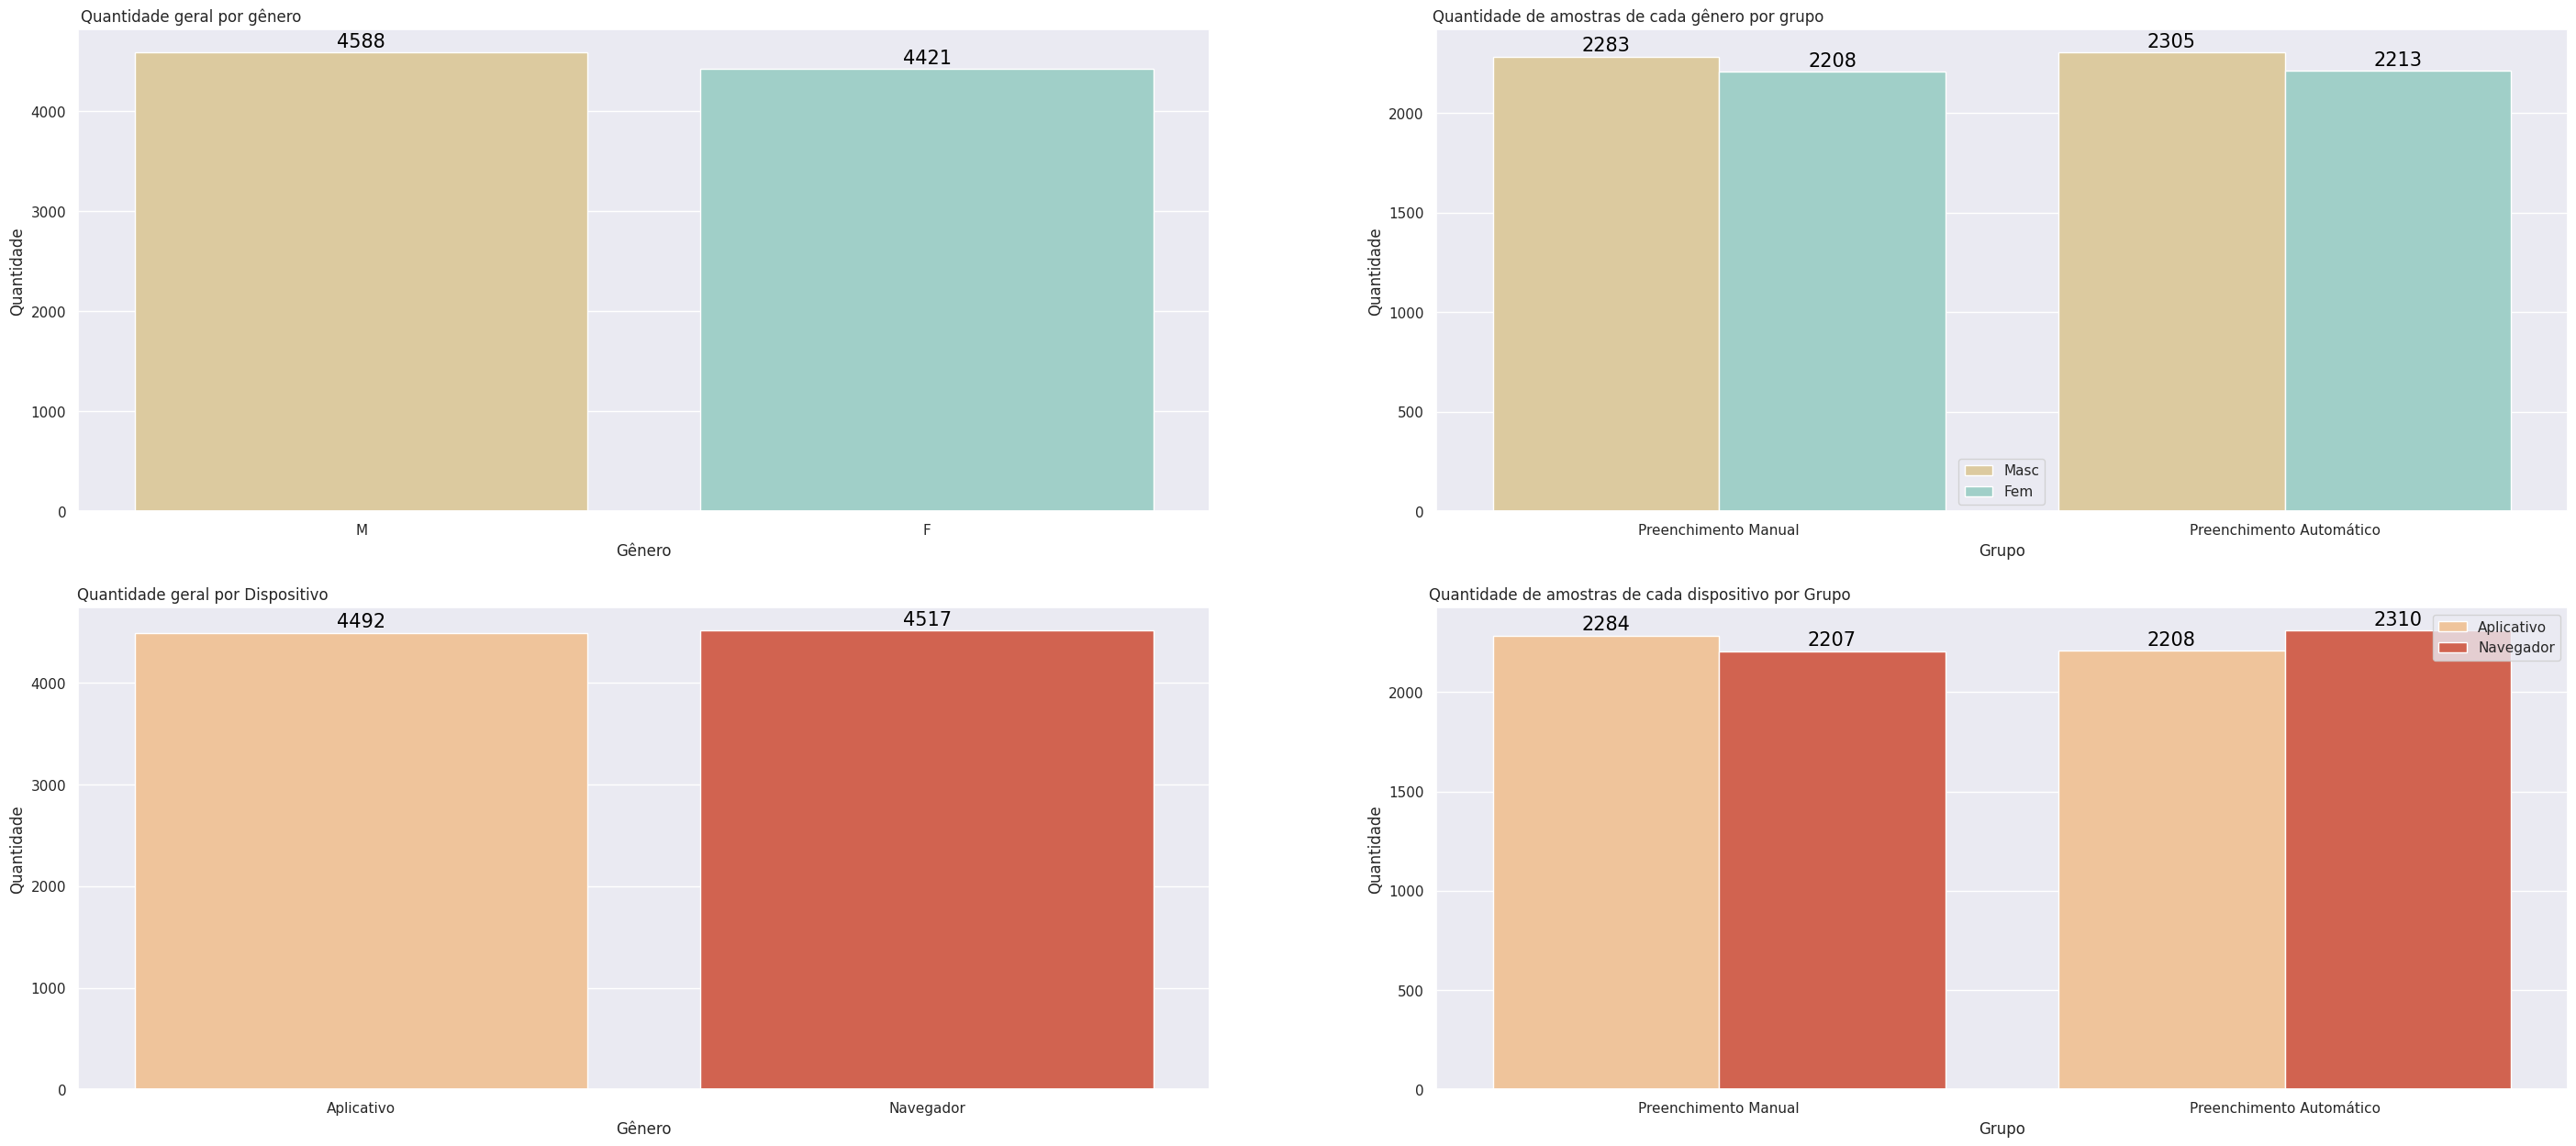

In [14]:
### Configuração dimensionamento plotagem gráfica
sns.set( rc = {'figure.figsize' : (35,15) } )

grid = GridSpec( 2,2 )

### Análise por gênero
## Gráfico 01
plt.subplot( grid[0,0] )
ax = sns.countplot(
    data    = df_br,
    x       = 'gender',    
    palette = 'BrBG' 
)
plt.title( 'Quantidade geral por gênero' , x = 0.1)
plt.xlabel( 'Gênero' )
plt.ylabel( 'Quantidade' )
rsl.plot_grafico.plot_values_vbar(ax);

## Gráfico 02
plt.subplot(grid[0,1])
ax = sns.countplot(
    data    = df_br,
    x       = 'group',
    hue     = 'gender',
    palette = 'BrBG' 
)
plt.title( 'Quantidade de amostras de cada gênero por grupo' , x = 0.17)
plt.xlabel( 'Grupo' )
plt.ylabel( 'Quantidade' )
ax.set_xticklabels( ['Preenchimento Manual', 'Preenchimento Automático'] )
plt.legend( ['Masc', 'Fem'] )
rsl.plot_grafico.plot_values_vbar(ax)


# --- Coluna 02 --- #

### Análise por dispositivo
## Gráfico 03
plt.subplot( grid[1,0] )
ax = sns.countplot(
    data    = df_br,
    x       = 'device',
    palette = 'OrRd' 
)
plt.title( 'Quantidade geral por Dispositivo' , x = 0.11)
plt.xlabel( 'Gênero' )
plt.ylabel( 'Quantidade' )
ax.set_xticklabels( ['Aplicativo', 'Navegador'] )
rsl.plot_grafico.plot_values_vbar(ax)


## Gráfico 04
plt.subplot( grid[1,1] )
ax = sns.countplot(
    data    = df_br,
    x       = 'group',
    hue     = 'device',
    palette = 'OrRd' 
)
plt.title( 'Quantidade de amostras de cada dispositivo por Grupo' , x = 0.18)
plt.xlabel( 'Grupo' )
plt.ylabel( 'Quantidade' )
plt.legend( ['Aplicativo', 'Navegador'] )
ax.set_xticklabels( ['Preenchimento Manual', 'Preenchimento Automático'] )
rsl.plot_grafico.plot_values_vbar(ax);

